# Class 4 — TensorFlow Regression with Fourier Features

We add **Fourier features** (`sin`/`cos`) to the scalar input so the model can learn and extrapolate seasonality without using sinusoidal activations.

In [ ]:
print("Hello, World!")

Hello, World!


## 1) Setup & Imports

We import the packages we need and also include a confirmation of the tensor flow version. with tensor flow versioning is important. it is suggested that we use a virtual environment, to fix the versions of the pacages and set the enviornment up exactly as we need it to be. this allows us to share and recreate on different machines. 

In [2]:

import os, math, random
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers, callbacks

print("TensorFlow:", tf.__version__)



ModuleNotFoundError: No module named 'numpy'

Below we set the seeding so we can reprduce. the worst is when you have fine tuned things perfectly and want to show a colleague something specific that has occured and are unable to reproduce. 

In [3]:
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

## 2) Generate data: sinusoid + linear trend + noise

Here we generate data. You could already have the data in a csv file or somehwere else and want to import it here. in this example we are creating synthetic data that might mimic the sales of medication (such as flu medication) which might have a seasonal component. in addition we add an upward trend which might suggest that the market is growing. 

We also added some noise to simulate some "real world" data which might not always be perfect. 

We then plot the data just to see what it currently looks like. In the example we can see the data is syclical in nature and also is trending upwards. 

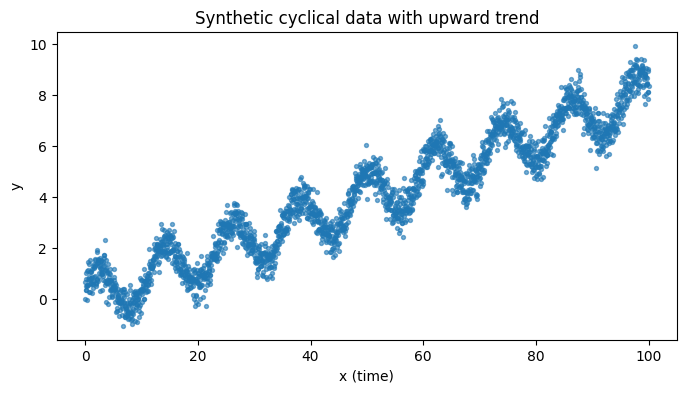

In [72]:

N = 2400
x_min, x_max = 0.0, 100.0 #X_max is the maximum time units so if 25 then there will be 25 time units that pass 
A = 1.0 #amplitude
omega = 2.0 * math.pi / 12.0 #frequency of the sine wave 
phi = 0.5 #shift left or right along x axis
beta = 0.08 #trend
sigma = 0.4 #noise level

x = np.linspace(x_min, x_max, N).astype(np.float32).reshape(-1,1)
noise = np.random.normal(0.0, sigma, size=N).astype(np.float32).reshape(-1,1)
y = (A * np.sin(omega * x + phi) + beta * x + noise).astype(np.float32)

plt.figure(figsize=(8,4))
plt.scatter(x, y, s=8, alpha=0.6)
plt.title("Synthetic cyclical data with upward trend")
plt.xlabel("x (time)"); plt.ylabel("y"); plt.show()


## 3) Fourier features

Adding these features which will be used to help the model understand that there may be cyclical or periodic like patterns in the data. DOMAIN KNOWLEDGE is important. we mentioned earlier that we simulating the data you might see in the sales of medications like for flu meds. 

In [82]:

def make_features(x, freqs):
    feats = [x]
    for f in freqs:
        feats += [np.sin(f * x), np.cos(f * x)]
    return np.concatenate(feats, axis=1).astype(np.float32)

freqs = (2*np.pi/3.0, 2*np.pi/4.0, 2*np.pi/6.0, 2*np.pi/12.0)  # fundamental + harmonic
X = make_features(x, freqs)
#X = x.reshape(-1, 1).astype(np.float32)
print("Feature shape:", X.shape)


Feature shape: (2400, 9)


## 4) Time-ordered split

Ok, we DO NOT shuffel the data because it is time based. we are not trying to identify clusters. we are trying to identify trends and for that we split the data in a way that the parts are consecutive. 

We introduce VALIDATION. this allows the model to check if it is learning or simpy memorizing the data and allows the brain to know when to stop training. then when we are done training is when we use the TESTING data. 

In [83]:
training_ratio = 0.6
validation_ratio = 0.2

N_total = len(X)
n_train = int(training_ratio * N_total)
n_val   = int(validation_ratio * N_total)
n_test  = N_total - n_train - n_val

X_train, y_train = X[:n_train], y[:n_train]
X_val,   y_val   = X[n_train:n_train+n_val], y[n_train:n_train+n_val]
X_test,  y_test  = X[n_train+n_val:], y[n_train+n_val:]

print("Shapes:", X_train.shape, X_val.shape, X_test.shape)


Shapes: (1440, 9) (480, 9) (480, 9)


## 5) Normalization (train only)

We are focussing only on the training data because we do not want to LEAK insights from the validation and the testing data into the model. WE DO NOT WANT TO CHEAT!

what we are doing is scaling the data so it its easier to train and work with. 

In [84]:

X_mean, X_std = X_train.mean(axis=0), X_train.std(axis=0)
y_mean, y_std = y_train.mean(), y_train.std()

def norm_X(A): return (A - X_mean) / (X_std + 1e-8)
def norm_y(a): return (a - y_mean) / (y_std + 1e-8)
def denorm_y(a): return a * (y_std + 1e-8) + y_mean

Xn_train, yn_train = norm_X(X_train), norm_y(y_train)
Xn_val,   yn_val   = norm_X(X_val),   norm_y(y_val)
Xn_test,  yn_test  = norm_X(X_test),  norm_y(y_test)


## 6) tf.data pipelines

ok, so now we are simply creating the datasets to feed into the model.

"but why a batch size of 64?"....thats because we need to be aware of resources and so we dont feed everything but feed it in bacthes. 

In [85]:

BATCH_SIZE = 64
train_ds = tf.data.Dataset.from_tensor_slices((Xn_train, yn_train)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds   = tf.data.Dataset.from_tensor_slices((Xn_val,   yn_val)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds  = tf.data.Dataset.from_tensor_slices((Xn_test,  yn_test)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


## 7) Model (ReLU MLP)

so now we build the brain. we are piecing together the layers to create the neural network an we are using ReLU activation. it is SEQUENTIAL so it means the layers come one after the other. 

input_dim: how maby features we are adding to the model

hidden_units: how many neurons in each hidden layer

activation: the activation function being used

l2: regularization strength

use_batchroom: should we include batch normalization layers

In [86]:

def build_model(input_dim, hidden_units=(64,64), activation="relu", l2=0.0, use_batchnorm=False):
    model = keras.Sequential([layers.Input(shape=(input_dim,))])
    for units in hidden_units:
        model.add(layers.Dense(units, activation=None,
                               kernel_regularizer=regularizers.l2(l2) if l2>0 else None))
        if use_batchnorm:
            model.add(layers.BatchNormalization())
        model.add(layers.Activation(activation))
    model.add(layers.Dense(1, activation="linear"))
    return model

model = build_model(input_dim=Xn_train.shape[1])
model.summary()


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_21 (Dense)                │ (None, 64)             │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_14 (Activation)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_15 (Activation)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,865 (19.00 KB)

 Trainable params: 4,865 (19.00 KB)

 Non-trainable params: 0 (0.00 B)

## 8) Compile & Train

how many times we move through the data set, and with each movement how big are the steps that we will adjust the weight changes. 

In [87]:

LR = 1e-3
EPOCHS = 300

model.compile(optimizer=keras.optimizers.Adam(learning_rate=LR),
              loss="mse", metrics=["mae"])

es  = callbacks.EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True)
rlr = callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=10, min_lr=1e-6, verbose=1)

history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=[es, rlr], verbose=0)
print("Best val_loss:", min(history.history["val_loss"]))



Epoch 110: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 120: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Best val_loss: 0.07648877799510956


### Learning curves

“This graph shows how the model’s error changed during training.
Both lines drop quickly, then flatten, which means the model learned the main pattern and stopped improving.
The validation loss staying close to the training loss tells us it’s not overfitting — the model is generalizing well.”

“If the model flattens much later, it’s learning too slowly — it’s struggling to pick up patterns.
If it flattens early but high, it hasn’t learned enough (underfitting).
Ideally, we want it to drop quickly, then flatten smoothly at a low loss — that means it’s learned efficiently.”

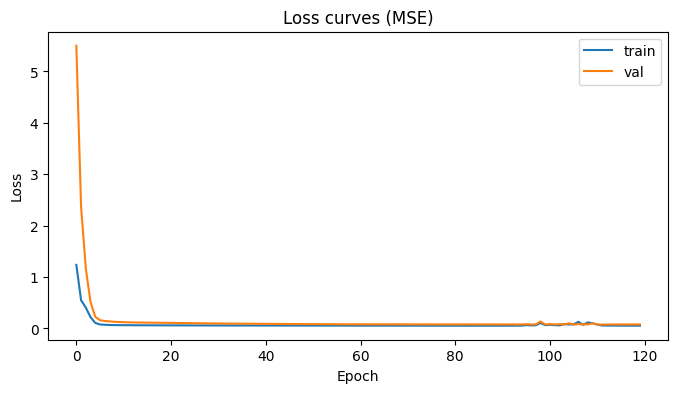

In [88]:

plt.figure(figsize=(8,4))
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="val")
plt.title("Loss curves (MSE)")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.show()


## 9) Evaluate & visualize predictions

Now that we’ve trained our model, we test it on new data that it has never seen before.
We plot the true values and the model’s predictions together — and as we can see, the predictions follow the real pattern quite closely.
The errors (MAE and RMSE) are small, which means our model understands the general trend and seasonality, not just the noise.

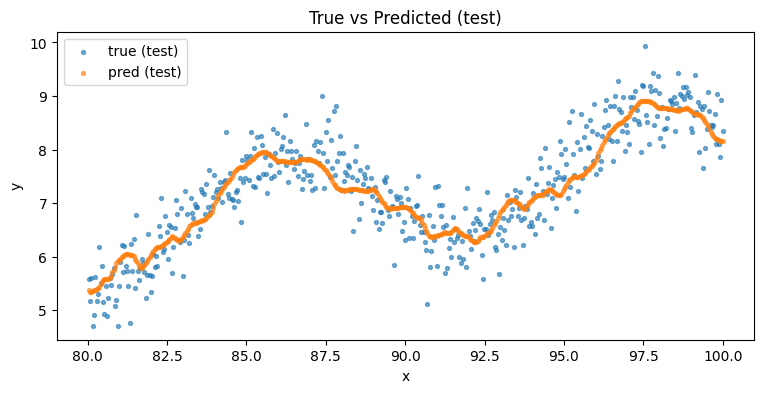

Test MAE: 0.2381
Test RMSE: 0.2982


In [89]:

y_pred_test = denorm_y(model.predict(Xn_test, verbose=0))

# Corresponding raw x for plotting
x_test = x[n_train+n_val:]
plt.figure(figsize=(9,4))
plt.scatter(x_test, y_test, s=8, alpha=0.6, label="true (test)")
plt.scatter(x_test, y_pred_test, s=8, alpha=0.6, label="pred (test)")
plt.title("True vs Predicted (test)"); plt.xlabel("x"); plt.ylabel("y")
plt.legend(); plt.show()

test_mse, test_mae = model.evaluate(test_ds, verbose=0)
print(f"Test MAE: {test_mae:.4f}")
print(f"Test RMSE: {float(np.sqrt(test_mse)):.4f}")


## 10) Predict y for a new x (uses Fourier features)

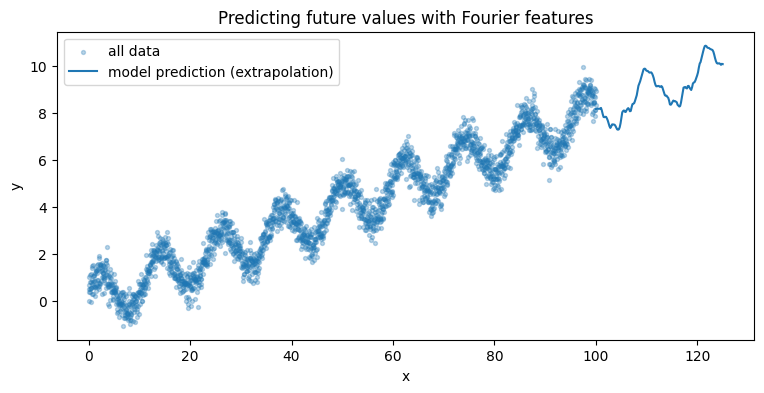

In [90]:

def predict_y(x_new, freqs=freqs):
    x_new = np.array(x_new, dtype=np.float32).reshape(-1,1)
    X_new = make_features(x_new, freqs=freqs)
    X_new_n = (X_new - X_mean) / (X_std + 1e-8)
    y_new_n = model.predict(X_new_n, verbose=0)
    return denorm_y(y_new_n).flatten()

# Demo extrapolation
x_future = np.linspace(float(x_max), float(x_max)+25.0, 150)
y_future = predict_y(x_future)

plt.figure(figsize=(9,4))
plt.scatter(x, y, s=8, alpha=0.3, label="all data")
plt.plot(x_future, y_future, label="model prediction (extrapolation)")
plt.title("Predicting future values with Fourier features")
plt.xlabel("x"); plt.ylabel("y"); plt.legend(); plt.show()


## 11) Hyperparameter playground

In [57]:

def train_once(hidden_units=(64,64), activation="relu", l2=0.0, batch_size=64, lr=1e-3, epochs=250, use_batchnorm=False, verbose=0):
    m = build_model(input_dim=Xn_train.shape[1], hidden_units=hidden_units, activation=activation, l2=l2, use_batchnorm=use_batchnorm)
    m.compile(optimizer=keras.optimizers.Adam(learning_rate=lr), loss="mse", metrics=["mae"])
    es = callbacks.EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True)
    rlr = callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=10, min_lr=1e-6, verbose=0)
    dtrain = tf.data.Dataset.from_tensor_slices((Xn_train, yn_train)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    dval   = tf.data.Dataset.from_tensor_slices((Xn_val,   yn_val)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    dtest  = tf.data.Dataset.from_tensor_slices((Xn_test,  yn_test)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    h = m.fit(dtrain, validation_data=dval, epochs=epochs, callbacks=[es, rlr], verbose=verbose)
    test_mse, test_mae = m.evaluate(dtest, verbose=0)
    return m, h, test_mse, test_mae

# Example experiment
m2, h2, mse2, mae2 = train_once(hidden_units=(128,128,64), activation="relu", l2=1e-4, batch_size=64, lr=5e-4, epochs=300)
print(f"Test MAE: {mae2:.4f}, Test RMSE: {float(np.sqrt(mse2)):.4f}")


Test MAE: 0.7744, Test RMSE: 0.9779


### Quick activation comparison

In [58]:

results = {}
for act in ["relu", "tanh", "elu", "silu"]:
    _, _, mse, mae = train_once(hidden_units=(128,128), activation=act, l2=1e-4, batch_size=64, lr=1e-3, epochs=200, verbose=0)
    results[act] = (float(np.sqrt(mse)), float(mae))
print("Activation -> (RMSE, MAE)")
for k, v in results.items():
    print(k, "->", (round(v[0],4), round(v[1],4)))


Activation -> (RMSE, MAE)
relu -> (0.9255, 0.7362)
tanh -> (0.9381, 0.7439)
elu -> (0.8983, 0.7155)
silu -> (0.9113, 0.726)
